<h2>Import the proper packages and clean data</h2>
<p style="font-size:17px;">bring in the dataset and display first few rows .</p>


In [194]:
import pandas as pd
import numpy as np
import sklearn.metrics as metric
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate, false_negative_rate, false_positive_rate
from fairlearn.reductions import DemographicParity, GridSearch






In [195]:
crime_data = pd.read_csv('communities-crime-clean.csv')
crime_data.head()
numerical_cols = crime_data.select_dtypes(include=['int64', 'float64']).columns
crime_data[numerical_cols] = crime_data[numerical_cols].astype(float)

print(crime_data.dtypes)

state                  float64
communityname           object
fold                   float64
population             float64
householdsize          float64
                        ...   
LandArea               float64
PopDens                float64
PctUsePubTrans         float64
LemasPctOfficDrugUn    float64
ViolentCrimesPerPop    float64
Length: 104, dtype: object


<h2>Distinguish A field "High Crime" which is True if the ViolentCrimesPerPop is more than 0.2</h2>

<h2>For this project, we will use this number as an example and baseline to categorize an area as high crime. Official methods to determine this are likely more in depth.</h2>


In [196]:
def sethighCrime(df):
    if df['ViolentCrimesPerPop'] > 0.2:
        return True
    else:
        return False
    
crime_data['highCrime'] = crime_data.apply(sethighCrime, axis=1)

def classify_privileged(row):
    if row['racepctblack'] > 0.5 or row['racePctHisp'] > 0.5:
        return False
    else:
        return True
crime_data['is_privileged'] = crime_data.apply(classify_privileged, axis=1)

print(crime_data.head())
percentage_instances = crime_data.groupby('highCrime').size() * 100 / len(crime_data)
print(percentage_instances)
print("----------------")
print("Percentage Positive Instance = {}\nPercentage Negative Instance = {} ".format(percentage_instances[1],percentage_instances[0]))



   state      communityname  fold  population  householdsize  racepctblack  \
0    1.0      Alabastercity   7.0        0.01           0.61          0.21   
1    1.0  AlexanderCitycity  10.0        0.01           0.41          0.55   
2    1.0       Annistoncity   3.0        0.03           0.34          0.86   
3    1.0         Athenscity   8.0        0.01           0.38          0.35   
4    1.0         Auburncity   1.0        0.04           0.37          0.32   

   racePctWhite  racePctAsian  racePctHisp  agePct12t21  ...  PctSameHouse85  \
0          0.83          0.02         0.01         0.41  ...            0.40   
1          0.57          0.01         0.00         0.47  ...            0.66   
2          0.30          0.04         0.01         0.41  ...            0.59   
3          0.71          0.04         0.01         0.39  ...            0.56   
4          0.70          0.21         0.02         1.00  ...            0.12   

   PctSameCity85  PctSameState85  LandArea  PopDen

C:\Users\ryand\AppData\Local\Temp\ipykernel_6460\3948184154.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_data['highCrime'] = crime_data.apply(sethighCrime, axis=1)
C:\Users\ryand\AppData\Local\Temp\ipykernel_6460\3948184154.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_data['is_privileged'] = crime_data.apply(classify_privileged, axis=1)
C:\Users\ryand\AppData\Local\Temp\ipykernel_6460\3948184154.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, inte

<h2>We will now split dataset into testing and training splits, Train a random forest model and make predictions with certain features dropped.</h2>
<p>We are dropping non-predictive features and non-numerical features</p>


In [197]:
X = crime_data.drop('ViolentCrimesPerPop', axis=1).drop('state', axis=1).drop('communityname', axis=1).drop('fold', axis=1).drop('highCrime', axis=1)
y = crime_data['highCrime']

print("Shape of X:", X.shape)
print("Length of y:", len(y))

Shape of X: (1993, 101)
Length of y: 1993


In [198]:
#split dataset into test and train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
print("training set size: ", X_train.shape, y_train.shape)
print("testing set size: ", X_test.shape, y_test.shape)

training set size:  (1594, 101) (1594,)
testing set size:  (399, 101) (399,)


<h1> NOTE: Work has been done to show the max_depth of 3 is where accuracy increases to. This is included below in order to counter overfitting in our randomForestClassifier Model </h1>
<h2> We will also train the model using Cross-Validation to ensure feature importances are not dependent on a particular train-test split</h2>

In [199]:
# initialize model with the max_depth of 3 
model = RandomForestClassifier(random_state=97, max_depth=3)


cv_results = cross_validate(model, X, y, cv=5, return_estimator=True, scoring=['accuracy', 'precision', 'recall', 'f1'])

print("Cross-validation accuracy: ", np.mean(cv_results['test_accuracy']))
print("Cross-validation precision: ", np.mean(cv_results['test_precision']))
print("Cross-validation recall: ", np.mean(cv_results['test_recall']))
print("Cross-validation F1-score: ", np.mean(cv_results['test_f1']))

feature_importances = np.mean([estimator.feature_importances_ for estimator in cv_results['estimator']], axis=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# test_df = X_test.copy()
# test_df['highCrime'] = y_test.values
# 
# pred_df = X_test.copy()
# pred_df['pred'] = y_pred
# 
# test_dataset = BinaryLabelDataset(df=test_df, label_names=['highCrime'], protected_attribute_names=['is_privileged'])
# pred_dataset = BinaryLabelDataset(df=pred_df, label_names=['pred'], protected_attribute_names=['is_privileged'])
# 
# metrics = ClassificationMetric(test_dataset, pred_dataset,
#                               privileged_groups=[{'is_privileged': 1}],  # Example privileged group
#                               unprivileged_groups=[{'is_privileged': 1}])  # Example unprivileged groups
# 
# # Print metrics
# print("Difference in mean outcomes:", metrics.mean_difference())
# print("Disparate impact:", metrics.disparate_impact())
# print("Equal opportunity difference:", metrics.equal_opportunity_difference())
# print("Average odds difference:", metrics.average_odds_difference())

Cross-validation accuracy:  0.8249102656137832
Cross-validation precision:  0.7993767949625191
Cross-validation recall:  0.7577639751552795
Cross-validation F1-score:  0.7766332566292163


<h1> We can see the results above in predicting high crime using a RFC. </h1>
<p1> Let's now try to find out the most predictive features in our model returning a high crime classification or not </h1>

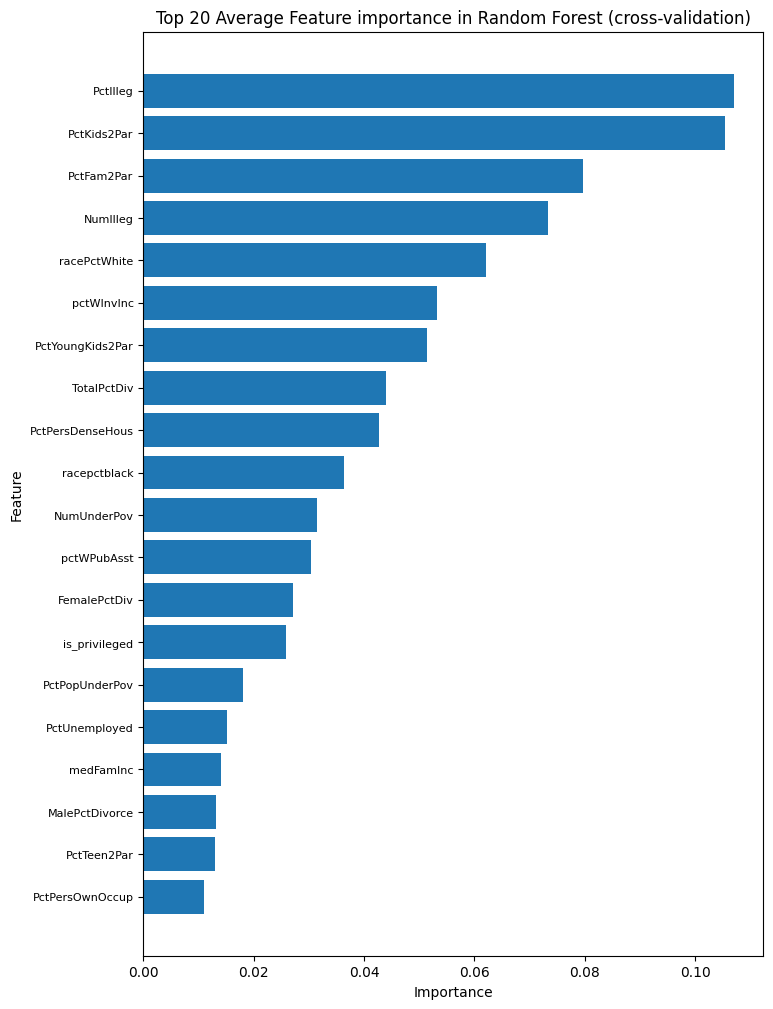

In [200]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance',ascending=False)
top_20_features = importance_df.head(20)

#Let's plot feature importances
plt.figure(figsize=(8, 12))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(fontsize=8)
plt.title('Top 20 Average Feature importance in Random Forest (cross-validation)')
plt.gca().invert_yaxis()
plt.show()

<h2> As we can see above, we gain crucial information about what our model is prioritizing to make predictions on 'high crime'. </h2>
<p> Let's now keep this information in mind as we continue to investigate for bias in our model </p>

<h1> Investigating Bias </h1>
<h2> Let's identify protected attributes based on the project proposal. The attributes I aim to protect are race (racePctWhite, racepctblack, racePctHisp)

<h1> Let's Start With Bias Towards or Against Certain Races </h1>
</h2> First, lets test all instances using a certain race and perform reports on all 3 race classes of importance. </h2>

In [201]:
def racePerformance1():
    for race in ['racePctWhite', 'racepctblack', 'racePctHisp']:
        print(f"performance for {race}:")
        mask = X_test[race] > 0.1
        print(classification_report(y_test[mask], y_pred[mask]))
racePerformance1()

performance for racePctWhite:
              precision    recall  f1-score   support

       False       0.86      0.89      0.87       249
        True       0.79      0.74      0.76       140

    accuracy                           0.84       389
   macro avg       0.82      0.81      0.82       389
weighted avg       0.83      0.84      0.83       389

performance for racepctblack:
              precision    recall  f1-score   support

       False       0.66      0.67      0.67        52
        True       0.83      0.82      0.83       102

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154

performance for racePctHisp:
              precision    recall  f1-score   support

       False       0.75      0.76      0.76        55
        True       0.79      0.78      0.79        64

    accuracy                           0.77       119
   macro avg       0.77      0.77      

<h2> Interestingly, it seems that the model in predicting high crime is more accurate in predicting "no high crime" for the White class. And following our results, we see the inverse with Black and Hispanic classes. Our model classifies high crime as "True" more accurately with the Black and Hispanic classes.  </h2>
<h3> This is a problem I want to address with potential re-weighing of these racial classes. It could a problem if our model accurately predicts high crime just because of racial factors. It could also be a case of unequal sample sizes. </h3>

<h1> lets try training the model again, but this time leave out the race features in our most predictive features. </h1>

In [202]:
X = crime_data.drop('ViolentCrimesPerPop', axis=1).drop('state', axis=1).drop('communityname', axis=1).drop('fold', axis=1).drop('highCrime', axis=1).drop('racePctWhite', axis=1).drop('racepctblack', axis=1).drop('racePctHisp', axis=1).drop('is_privileged', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)

model = RandomForestClassifier(random_state=97, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cv_results = cross_validate(model, X, y, cv=5, return_estimator=True, scoring=['accuracy', 'precision', 'recall', 'f1'])

print("Cross-validation accuracy: ", np.mean(cv_results['test_accuracy']))
print("Cross-validation precision: ", np.mean(cv_results['test_precision']))
print("Cross-validation recall: ", np.mean(cv_results['test_recall']))
print("Cross-validation F1-score: ", np.mean(cv_results['test_f1']))

feature_importances = np.mean([estimator.feature_importances_ for estimator in cv_results['estimator']], axis=0)

Cross-validation accuracy:  0.8223964433697308
Cross-validation precision:  0.7906411184210118
Cross-validation recall:  0.7627329192546584
Cross-validation F1-score:  0.7753351090788986


<h1> Past Results Compared to New (w/o important race features) </h1>
<h3> Cross-validation accuracy:  0.824 -> 0.822 </h3 
<h3> Cross-validation precision:  0.799 -> 0.790 </h3>
<h3> Cross-validation recall:  0.757 -> 0.762 </h3>
<h3> Cross-validation F1-score:  0.776 -> 0.775 </h3>

<h2> So overall, our predictive performance went down marginally when taking important race features out of the model. </h2>


<h1> Lets retrain using reweighted Race classes, and see how our model changes in certain metrics </h1>

In [203]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Reweighing the training data
# Protected attributes
protected_attributes = crime_data[['racePctWhite', 'racepctblack', 'racePctHisp']]

# Combine features and target for AIF360
data = X.copy()
data['highCrime'] = y
data['racePctWhite'] = protected_attributes['racePctWhite']
data['racepctblack'] = protected_attributes['racepctblack']
data['racePctHisp'] = protected_attributes['racePctHisp']

# Create AIF360 BinaryLabelDataset
dataset = BinaryLabelDataset(
    df=data,
    label_names=['highCrime'],
    protected_attribute_names=['racePctWhite', 'racepctblack', 'racePctHisp']
)

# Split dataset into train and test
train, test = dataset.split([0.8], shuffle=True, seed=97)
X_train = train.features
y_train = train.labels.ravel()
prot_train = train.protected_attributes
X_test = test.features
y_test = test.labels.ravel()
prot_test = test.protected_attributes

print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

# Initialize model with the max_depth of 3
model = RandomForestClassifier(random_state=97, max_depth=3)

# Cross-validate without reweighing
cv_results = cross_validate(model, X, y, cv=5, return_estimator=True, scoring=['accuracy', 'precision', 'recall', 'f1'])

print("Cross-validation accuracy:", np.mean(cv_results['test_accuracy']))
print("Cross-validation precision:", np.mean(cv_results['test_precision']))
print("Cross-validation recall:", np.mean(cv_results['test_recall']))
print("Cross-validation F1-score:", np.mean(cv_results['test_f1']))

# Reweighing the training data
RW = Reweighing(unprivileged_groups=[{'racePctWhite': 0, 'racepctblack': 1, 'racePctHisp': 1}],
                privileged_groups=[{'racePctWhite': 1, 'racepctblack': 0, 'racePctHisp': 0}])
train_reweighed = RW.fit_transform(train)

# Retrain the model with reweighted data
model.fit(X_train, y_train, sample_weight=train_reweighed.instance_weights)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy after reweighing: {accuracy}")
print(f"Precision after reweighing: {precision}")
print(f"Recall after reweighing: {recall}")
print(f"F1-score after reweighing: {f1}")



Training set size: (1594, 100) (1594,)
Testing set size: (399, 100) (399,)
Cross-validation accuracy: 0.8223964433697308
Cross-validation precision: 0.7906411184210118
Cross-validation recall: 0.7627329192546584
Cross-validation F1-score: 0.7753351090788986


C:\Users\ryand\AppData\Roaming\Python\Python310\site-packages\aif360\algorithms\preprocessing\reweighing.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
C:\Users\ryand\AppData\Roaming\Python\Python310\site-packages\aif360\algorithms\preprocessing\reweighing.py:68: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
C:\Users\ryand\AppData\Roaming\Python\Python310\site-packages\aif360\algorithms\preprocessing\reweighing.py:69: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_unfav = n_unfav*n_up / (n*n_up_unfav)


Accuracy after reweighing: 0.8546365914786967
Precision after reweighing: 0.8343558282208589
Recall after reweighing: 0.8143712574850299
F1-score after reweighing: 0.8242424242424242


<h1> Let's now run all three race classes and see their performance after reweighing. </h1>

In [204]:
from sklearn.metrics import classification_report

def racePerformance2():
    for race, index in zip(['racePctWhite', 'racepctblack', 'racePctHisp'], [0, 1, 2]):
        print(f"Performance for {race}:")
        mask = prot_test[:, index] > 0.1  # 0.1 threshold
        print(classification_report(y_test[mask], y_pred[mask]))

racePerformance2()


Performance for racePctWhite:
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88       230
         1.0       0.82      0.80      0.81       156

    accuracy                           0.85       386
   macro avg       0.84      0.84      0.84       386
weighted avg       0.85      0.85      0.85       386

Performance for racepctblack:
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79        50
         1.0       0.88      0.96      0.92       110

    accuracy                           0.88       160
   macro avg       0.89      0.83      0.85       160
weighted avg       0.88      0.88      0.88       160

Performance for racePctHisp:
              precision    recall  f1-score   support

         0.0       0.74      0.64      0.69        53
         1.0       0.78      0.85      0.81        78

    accuracy                           0.76       131
   macro avg       0.76      0.74      